In [ ]:
# ----------------------------------------------------------------------------
# --- LOADING TOOLS AND DATA
# ----------------------------------------------------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, roc_curve, auc, 
                             log_loss, roc_auc_score)
from sklearn.preprocessing import label_binarize
import xgboost as xgb
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*60)
print("LOADING DATASET: WINE QUALITY")
print("="*60)

BASE_DIR = Path().resolve()
DATA_DIR = BASE_DIR / "data"

wine = pd.read_csv(DATA_DIR / "wineQuality/winequality-white.csv", sep=";")

print(f"\nDataset shape: {wine.shape}")
print(f"\nFirst rows:\n{wine.head()}")
print(f"\nQuality distribution:\n{wine['quality'].value_counts().sort_index()}")

# Features and target
X = wine.drop('quality', axis=1)
# low (0-5), medium (6), high (7-10)
quality_quantiles = wine['quality'].quantile([0, 1/3, 2/3, 1])
y = pd.cut(wine['quality'], 
           bins=quality_quantiles, 
           labels=['low', 'medium', 'high'],
           include_lowest=True)

print(f"\nClasses distribution:\n{y.value_counts()}")

# utility for XGBoost
le = LabelEncoder()
y_xgb = le.fit_transform(y)

# Table: og quality vs classes
cross_tab = pd.crosstab(wine['quality'], y, margins=True)
print(f"\nQuality vs Classes:\n{cross_tab}")

# Check NA
na_count = X.isnull().sum().sum()
print(f"\nMissing values: {na_count}")

# Check constant values
constant_cols = [col for col in X.columns if X[col].nunique() == 1]
if constant_cols:
    print(f"Constant columns: {constant_cols}")
    X = X.drop(columns=constant_cols)

LOADING DATASET: WINE QUALITY

Dataset shape: (4898, 12)

First rows:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  qual

In [ ]:
# ----------------------------------------------------------------------------
# --- K-FOLD CROSS-VALIDATION REGRESSION
# ----------------------------------------------------------------------------

print("\n" + "="*60)
print("K-FOLD CROSS-VALIDATION")
print("="*60)

K = 5
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=123)
n_classes = len(y.unique())
class_labels = sorted(y.unique().tolist())

# --- SUPPORT FUNCTIONS

def compute_metrics(y_true, y_pred, y_prob=None):
    acc = accuracy_score(y_true, y_pred)
    
    # Macro-averaged metrics
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    
    # Log-loss
    logloss = None
    if y_prob is not None:
        try:
            logloss = log_loss(y_true, y_prob)
        except:
            logloss = np.nan
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=class_labels)
    
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'logloss': logloss,
        'confusion_matrix': cm
    }

# --- DEFINE MODELS

models = {
    'multinom': LogisticRegression(solver='lbfgs', 
                                    max_iter=1000, random_state=42),
    'ridge': LogisticRegression(penalty='l2', C=1.0,
                                solver='lbfgs', max_iter=1000, random_state=42),
    'lasso': LogisticRegression(penalty='l1', C=1.0,
                                solver='saga', max_iter=1000, random_state=42),
    'enet': LogisticRegression(penalty='elasticnet', C=1.0, l1_ratio=0.5,
                               solver='saga', max_iter=1000, random_state=42),
    'tree': DecisionTreeClassifier(max_depth=10, random_state=42),
    'rf': RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1),
    'xgb': xgb.XGBClassifier(n_estimators=300, learning_rate=0.1, max_depth=6,
                             random_state=42, n_jobs=-1, eval_metric='mlogloss'),
    'nb': GaussianNB(),
    'svm': SVC(kernel='linear', probability=True, random_state=42),
    'svm_rbf': SVC(kernel='rbf', probability=True, random_state=42)
}

model_labels = {
    'multinom': 'Multinomial Logistic',
    'ridge': 'Ridge Logistic',
    'lasso': 'Lasso Logistic',
    'enet': 'Elastic Net',
    'tree': 'Classification Tree',
    'rf': 'Random Forest',
    'xgb': 'XGBoost',
    'nb': 'Naive Bayes',
    'svm': 'SVM (Linear)',
    'svm_rbf': 'SVM (RBF)'
}

# --- START LOOP FOR CV

predictions_all = {model_name: {'y_true': [], 'y_pred': [], 'y_prob': []} 
                   for model_name in models.keys()}

fold_metrics = {model_name: [] for model_name in models.keys()}

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n--- FOLD {fold}/{K} ---")
    
    # Split
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Model by model
    for model_name, model in models.items():
        # Model Clone for this fold
        from sklearn.base import clone
        model_fold = clone(model)
        
        # --- Handle y for XGBoost only
        if model_name == 'xgb':
            y_train_fold = y_xgb[train_idx]
            y_test_fold  = y_xgb[test_idx]
        else:
            y_train_fold = y_train
            y_test_fold  = y_test

        # Train
        model_fold.fit(X_train, y_train_fold)

        # Predict
        y_pred = model_fold.predict(X_test)
        y_prob = model_fold.predict_proba(X_test)

        # Convert XGB predictions back to labels
        if model_name == 'xgb':
            y_pred = le.inverse_transform(y_pred)
        
        # Save predictions
        predictions_all[model_name]['y_true'].extend(y_test.values)
        predictions_all[model_name]['y_pred'].extend(y_pred)
        predictions_all[model_name]['y_prob'].extend(y_prob)
        
        # Metrics per fold
        metrics = compute_metrics(y_test, y_pred, y_prob)
        fold_metrics[model_name].append(metrics)

print("\n K-Fold CV completed!")


K-FOLD CROSS-VALIDATION

--- FOLD 1/5 ---

--- FOLD 2/5 ---

--- FOLD 3/5 ---

--- FOLD 4/5 ---

--- FOLD 5/5 ---

 K-Fold CV completed!



PRESENTING THE RESULTS: MODELS COMPARISON

               Model  Accuracy_mean  Accuracy_sd  F1_mean  LogLoss_mean
       Random Forest       0.726624     0.009625 0.723230      0.622152
             XGBoost       0.712535     0.007666 0.709967      0.681675
 Classification Tree       0.619230     0.017115 0.605635      4.171490
Multinomial Logistic       0.565124     0.013700 0.521531      0.897525
      Ridge Logistic       0.565124     0.013700 0.521531      0.897525
        SVM (Linear)       0.548382     0.015282 0.409271      0.889334
         Elastic Net       0.510614     0.007477 0.461185      0.944954
      Lasso Logistic       0.510002     0.007204 0.460422      0.945119
         Naive Bayes       0.497751     0.009981 0.501929      1.227699
           SVM (RBF)       0.472439     0.010310 0.330744      0.962405

Best model: Random Forest
Mean Accuracy: 0.7266 ± 0.0096
Mean F1-Score: 0.7232


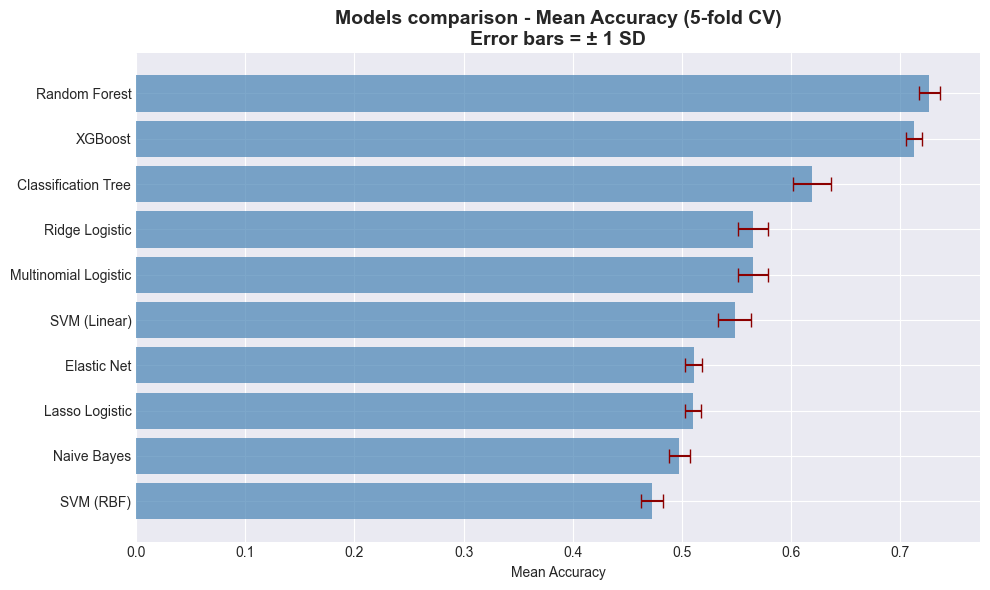

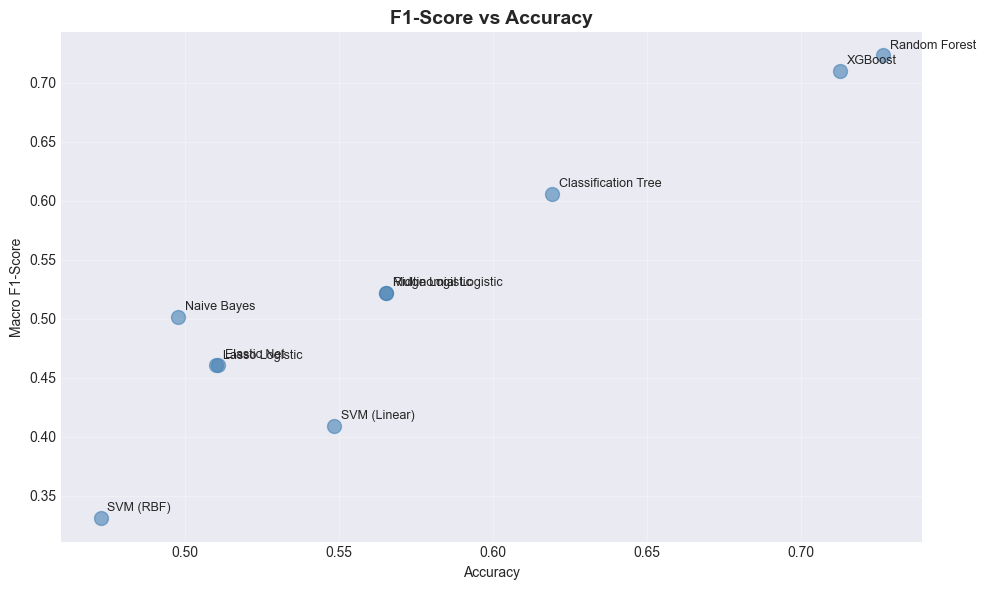

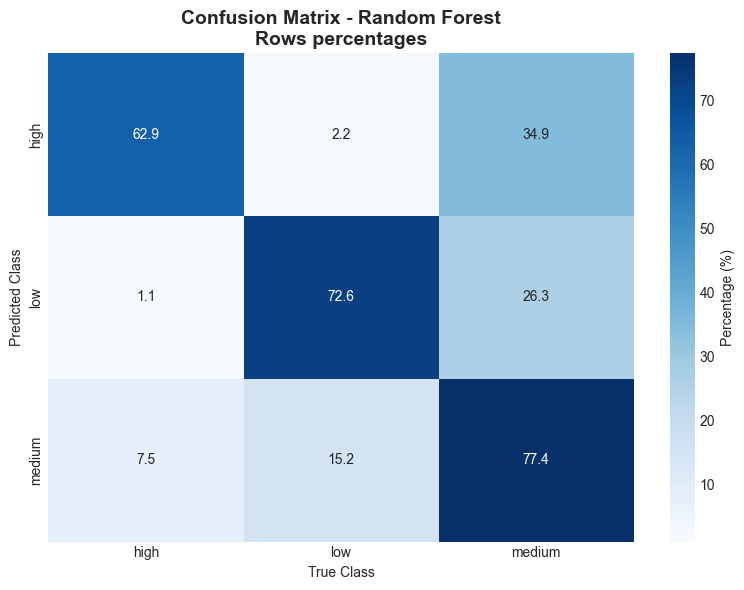

In [ ]:
# ----------------------------------------------------------------------------
# --- RESULTS AGGREGATION
# ----------------------------------------------------------------------------

print("\n" + "="*60)
print("PRESENTING THE RESULTS: MODELS COMPARISON")
print("="*60)

cv_results = []
confusion_matrices = {}

for model_name in models.keys():
    # Metrics per fold
    acc_folds = [m['accuracy'] for m in fold_metrics[model_name]]
    f1_folds = [m['f1'] for m in fold_metrics[model_name]]
    prec_folds = [m['precision'] for m in fold_metrics[model_name]]
    rec_folds = [m['recall'] for m in fold_metrics[model_name]]
    ll_folds = [m['logloss'] for m in fold_metrics[model_name] if m['logloss'] is not None]
    
    # Global metrics
    y_true_all = np.array(predictions_all[model_name]['y_true'])
    y_pred_all = np.array(predictions_all[model_name]['y_pred'])
    y_prob_all = np.array(predictions_all[model_name]['y_prob'])
    global_metrics = compute_metrics(y_true_all, y_pred_all, y_prob_all)
    confusion_matrices[model_name] = global_metrics['confusion_matrix']
    
    cv_results.append({
        'Model': model_labels[model_name],
        'Model_Code': model_name,
        'Accuracy_mean': np.mean(acc_folds),
        'Accuracy_sd': np.std(acc_folds, ddof=1),
        'F1_mean': np.mean(f1_folds),
        'F1_sd': np.std(f1_folds, ddof=1),
        'Precision_mean': np.mean(prec_folds),
        'Recall_mean': np.mean(rec_folds),
        'LogLoss_mean': np.mean(ll_folds) if ll_folds else np.nan,
        'Accuracy_global': global_metrics['accuracy']
    })

# DataFrame results
cv_summary = pd.DataFrame(cv_results).sort_values('Accuracy_mean', ascending=False)

print("\n" + cv_summary[['Model', 'Accuracy_mean', 'Accuracy_sd', 'F1_mean', 'LogLoss_mean']].to_string(index=False))

# Best model
best_model_row = cv_summary.iloc[0]
best_model_name = best_model_row['Model']
best_model_code = best_model_row['Model_Code']
best_acc = best_model_row['Accuracy_mean']
best_sd = best_model_row['Accuracy_sd']

print(f"\nBest model: {best_model_name}")
print(f"Mean Accuracy: {best_acc:.4f} ± {best_sd:.4f}")
print(f"Mean F1-Score: {best_model_row['F1_mean']:.4f}")

# --- VISUALS

# Plot 1: Accuracy and error bars comparison
fig, ax = plt.subplots(figsize=(10, 6))
cv_summary_sorted = cv_summary.sort_values('Accuracy_mean', ascending=True)
y_pos = np.arange(len(cv_summary_sorted))

ax.barh(y_pos, cv_summary_sorted['Accuracy_mean'], alpha=0.7, color='steelblue')
ax.errorbar(cv_summary_sorted['Accuracy_mean'], y_pos, 
            xerr=cv_summary_sorted['Accuracy_sd'], 
            fmt='none', ecolor='darkred', capsize=5)
ax.set_yticks(y_pos)
ax.set_yticklabels(cv_summary_sorted['Model'])
ax.set_xlabel('Mean Accuracy')
ax.set_title('Models comparison - Mean Accuracy (5-fold CV)\nError bars = ± 1 SD', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Plot 2: F1-Score vs Accuracy
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(cv_summary['Accuracy_mean'], cv_summary['F1_mean'], 
           s=100, alpha=0.6, color='steelblue')
for idx, row in cv_summary.iterrows():
    ax.annotate(row['Model'], 
                (row['Accuracy_mean'], row['F1_mean']),
                xytext=(5, 5), textcoords='offset points', fontsize=9)
ax.set_xlabel('Accuracy')
ax.set_ylabel('Macro F1-Score')
ax.set_title('F1-Score vs Accuracy', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 3: Confusion Matrix best model
cm_best = confusion_matrices[best_model_code]
cm_pct = cm_best.astype('float') / cm_best.sum(axis=1)[:, np.newaxis] * 100

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_pct, annot=True, fmt='.1f', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels,
            cbar_kws={'label': 'Percentage (%)'})
ax.set_xlabel('True Class')
ax.set_ylabel('Predicted Class')
ax.set_title(f'Confusion Matrix - {best_model_name}\nRows percentages', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


RE-RUNNING THE BEST MODEL ON THE DATA

Final model: Random Forest
Adapted on 4898 observations

Accuracy: 1.0000
Macro Precision: 1.0000
Macro Recall: 1.0000
Macro F1-Score: 1.0000

Confusion Matrix
        high   low  medium
high    1060     0       0
low        0  1640       0
medium     0     0    2198
  high: Precision=1.0000, Recall=1.0000, F1=1.0000
  low: Precision=1.0000, Recall=1.0000, F1=1.0000
  medium: Precision=1.0000, Recall=1.0000, F1=1.0000

Variable Importance:
            Variable  Importance  Importance_Pct
             alcohol    0.125007       12.500720
             density    0.107036       10.703647
    volatile acidity    0.101533       10.153265
 free sulfur dioxide    0.095047        9.504700
total sulfur dioxide    0.089270        8.926963
      residual sugar    0.087021        8.702101
           chlorides    0.084221        8.422106
                  pH    0.084067        8.406677
         citric acid    0.079515        7.951517
           sulphates    0.

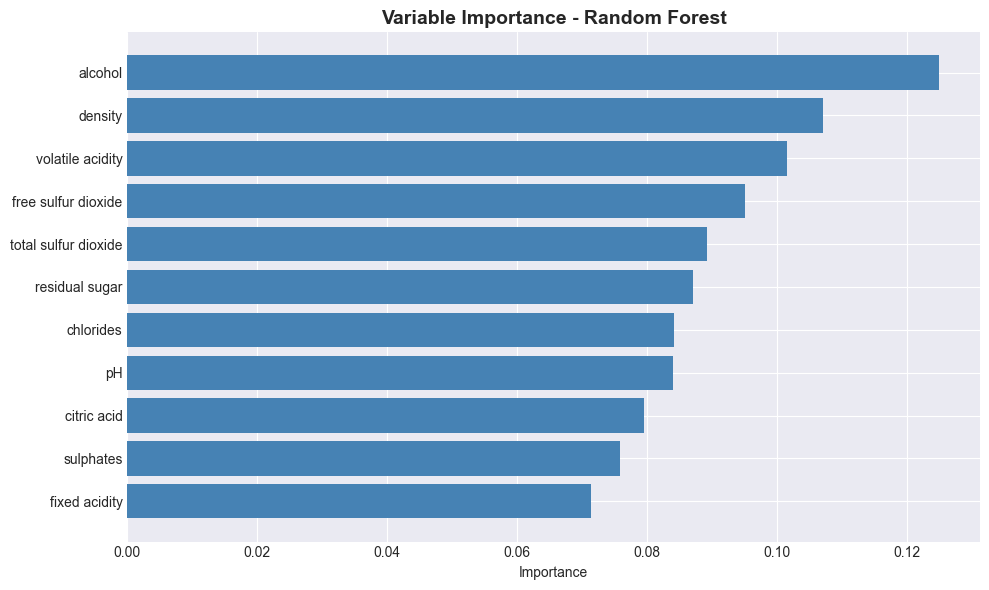


Max probability statistics:
Mean : 0.8609
Median: 0.8680
Min: 0.6060
Max: 1.0000

Confidence for correctly classified and misclassified predicitons
Correctly classified (n=4898): 0.8609
Misclassified  (n=0): nan


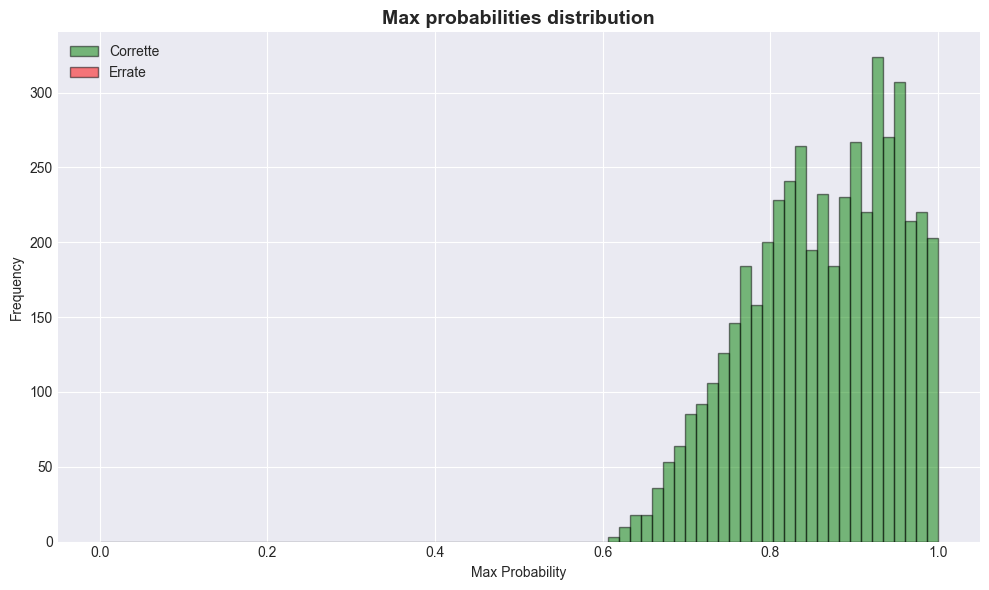

Classe high - AUC: 1.0000
Classe low - AUC: 1.0000
Classe medium - AUC: 1.0000


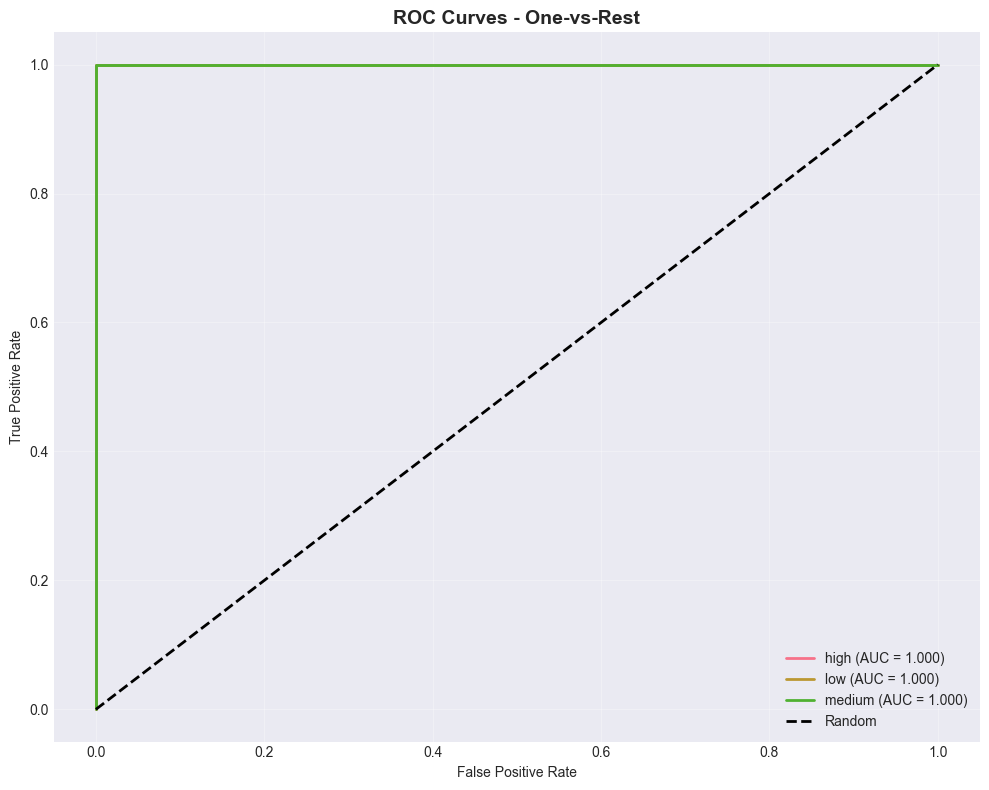


Mean AUC (macro): 1.0000

SUMMARY TABLE OF RESULTS

             Metric         Value
              Model Random Forest
     n observations          4898
         n features            11
          n classes             3
 CV Accuracy (mean)        0.7266
   CV Accuracy (sd)        0.0096
 CV F1-Score (mean)        0.7232
CV Precision (mean)        0.7461
   CV Recall (mean)        0.7098
  Training Accuracy        1.0000
  Training F1-Score        1.0000
          AUC medio        1.0000

Prediction for a wine with average characteristics
  high: 8.40%
  low: 26.60%
  medium: 65.00%

Predicted class: medium

COMPLETED

Saved files:
- final_model_rf.pkl
- cv_classification_results.csv
- summary_classification.csv


In [ ]:
# ----------------------------------------------------------------------------
# --- RE-RUNNING OF BEST MODEL ON ENTIRE DATASET
# ----------------------------------------------------------------------------

print("\n" + "="*60)
print("RE-RUNNING THE BEST MODEL ON THE DATA")
print("="*60)

from sklearn.base import clone
final_model = clone(models[best_model_code])
final_model.fit(X, y)

print(f"\nFinal model: {best_model_name}")
print(f"Adapted on {len(y)} observations")

# save model
import pickle
with open(f'final_model_{best_model_code}.pkl', 'wb') as f:
    pickle.dump(final_model, f)

# --- BEST MODEL ANALYSIS: RANDOM FOREST

# Predictions on training set
y_pred_train = final_model.predict(X)
y_prob_train = final_model.predict_proba(X)
train_metrics = compute_metrics(y, y_pred_train, y_prob_train)
cm_train = train_metrics['confusion_matrix']

print(f"\nAccuracy: {train_metrics['accuracy']:.4f}")
print(f"Macro Precision: {train_metrics['precision']:.4f}")
print(f"Macro Recall: {train_metrics['recall']:.4f}")
print(f"Macro F1-Score: {train_metrics['f1']:.4f}")

print("\nConfusion Matrix")
cm_df = pd.DataFrame(cm_train, index=class_labels, columns=class_labels)
print(cm_df)

# Metrics by class
for i, cls in enumerate(class_labels):
    tp = cm_train[i, i]
    fp = cm_train[:, i].sum() - tp
    fn = cm_train[i, :].sum() - tp
    tn = cm_train.sum() - tp - fp - fn
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0
    rec = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_cls = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0
    print(f"  {cls}: Precision={prec:.4f}, Recall={rec:.4f}, F1={f1_cls:.4f}")

# FEATURE IMPORTANCE ANALYSIS

if best_model_code in ['rf', 'xgb', 'tree']:
    
    if hasattr(final_model, 'feature_importances_'):
        importances = final_model.feature_importances_
        
        importance_df = pd.DataFrame({
            'Variable': X.columns,
            'Importance': importances
        }).sort_values('Importance', ascending=False)
        
        importance_df['Importance_Pct'] = 100 * importance_df['Importance'] / importance_df['Importance'].sum()
        
        print("\nVariable Importance:")
        print(importance_df.to_string(index=False))
        
        # Plot importance
        fig, ax = plt.subplots(figsize=(10, 6))
        importance_sorted = importance_df.sort_values('Importance', ascending=True)
        y_pos = np.arange(len(importance_sorted))
        ax.barh(y_pos, importance_sorted['Importance'], color='steelblue')
        ax.set_yticks(y_pos)
        ax.set_yticklabels(importance_sorted['Variable'])
        ax.set_xlabel('Importance')
        ax.set_title(f'Variable Importance - {best_model_name}', 
                     fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

# PROBABILITY AND CONFIDENCE

max_probs = y_prob_train.max(axis=1)
pred_correct = (y_pred_train == y.values)

print(f"\nMax probability statistics:")
print(f"Mean : {max_probs.mean():.4f}")
print(f"Median: {np.median(max_probs):.4f}")
print(f"Min: {max_probs.min():.4f}")
print(f"Max: {max_probs.max():.4f}")

print(f"\nConfidence for correctly classified and misclassified predicitons")
print(f"Correctly classified (n={pred_correct.sum()}): {max_probs[pred_correct].mean():.4f}")
print(f"Misclassified  (n={(~pred_correct).sum()}): {max_probs[~pred_correct].mean():.4f}")

# Plot: probability distribution
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(max_probs[pred_correct], bins=30, alpha=0.5, label='Corrette', 
        color='green', edgecolor='black')
ax.hist(max_probs[~pred_correct], bins=30, alpha=0.5, label='Errate', 
        color='red', edgecolor='black')
ax.set_xlabel('Max Probability')
ax.set_ylabel('Frequency')
ax.set_title('Max probabilities distribution', fontsize=14, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

# ROC CURVES (One-vs-Rest)

y_bin = label_binarize(y, classes=class_labels)
fig, ax = plt.subplots(figsize=(10, 8))

for i, cls in enumerate(class_labels):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_prob_train[:, i])
    roc_auc = auc(fpr, tpr)
    
    ax.plot(fpr, tpr, lw=2, label=f'{cls} (AUC = {roc_auc:.3f})')
    print(f"Classe {cls} - AUC: {roc_auc:.4f}")

ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves - One-vs-Rest', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Mean AUC
auc_scores = [auc(*roc_curve(y_bin[:, i], y_prob_train[:, i])[:2]) 
              for i in range(n_classes)]
print(f"\nMean AUC (macro): {np.mean(auc_scores):.4f}")

# --- SUMMARY

print("\n" + "="*60)
print("SUMMARY TABLE OF RESULTS")
print("="*60)

summary_data = {
    'Metric': [
        'Model',
        'n observations',
        'n features',
        'n classes',
        'CV Accuracy (mean)',
        'CV Accuracy (sd)',
        'CV F1-Score (mean)',
        'CV Precision (mean)',
        'CV Recall (mean)',
        'Training Accuracy',
        'Training F1-Score',
        'AUC medio'
    ],
    'Value': [
        best_model_name,
        str(len(y)),
        str(X.shape[1]),
        str(n_classes),
        f"{best_model_row['Accuracy_mean']:.4f}",
        f"{best_model_row['Accuracy_sd']:.4f}",
        f"{best_model_row['F1_mean']:.4f}",
        f"{best_model_row['Precision_mean']:.4f}",
        f"{best_model_row['Recall_mean']:.4f}",
        f"{train_metrics['accuracy']:.4f}",
        f"{train_metrics['f1']:.4f}",
        f"{np.mean(auc_scores):.4f}"
    ]
}

summary_table = pd.DataFrame(summary_data)
print("\n" + summary_table.to_string(index=False))

# PREDICTION EXAMPLE

# Wine with average characteristics
new_wine = X.mean().to_frame().T
pred_prob_new = final_model.predict_proba(new_wine)[0]
pred_class_new = final_model.predict(new_wine)[0]

print("\nPrediction for a wine with average characteristics")
for i, cls in enumerate(class_labels):
    print(f"  {cls}: {pred_prob_new[i]*100:.2f}%")
print(f"\nPredicted class: {pred_class_new}")

# save results
cv_summary.to_csv('cv_classification_results.csv', index=False)
summary_table.to_csv('summary_classification.csv', index=False)

print("\n" + "="*60)
print("COMPLETED")
print("="*60)
print("\nSaved files:")
print(f"- final_model_{best_model_code}.pkl")
print("- cv_classification_results.csv")
print("- summary_classification.csv")